# BMI707 Project

Group 1: Adele Collin, Kyla Gabriel, Chuck Lin, Ritvik Raina, Sofia Rojas

ConvNN for detection of COVID from CT-Scans

# Loading packages and Data Exploration

In [ ]:
#import relevant packagaes
import os
import shutil
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, image as img
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import cv2


from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report

#!python3 -m pip install visualkeras
#import visualkeras #only works on google collab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#load data
path = "/content/drive/MyDrive/BMI707/BMI707_Code" #"curated_data"

Classes = ["Covid","Normal"]

covid_img = np.load(os.path.join(path,"Covid.npy")) #load the numpy array of images
normal_img = np.load(os.path.join(path,"Normal.npy"))

In [ ]:
# To visualize the dataset
num_normal = len(normal_img)
num_covid = len(covid_img)

print("Training Set:")
print("Number of Normal Lung X-rays: {}".format(num_normal))
print("Number of Lung X-rays with COVID: {}".format(num_covid))
print("Total number of images: {}".format(num_normal+num_covid))

Training Set:
Number of Normal Lung X-rays: 6893
Number of Lung X-rays with COVID: 7593
Total number of images: 14486


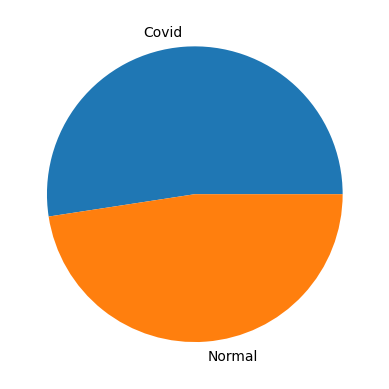

In [ ]:
#vizualize the distribution
plt.pie(np.array([num_covid,num_normal]),labels=Classes)
plt.show()

#almost balanced dataset

# Convolutional Neural Network (Bottom Up)

In [ ]:
#define some variables
BATCH = 64
img_size = 128
epochs = 20

In [ ]:
#Covid - 1
#Normal - 0

c_copy = covid_img
c_labels = [1 for i in c_copy]
n_copy = normal_img
n_labels = [0 for i in n_copy]


x = np.concatenate([c_copy, n_copy])
y = np.array((c_labels + n_labels))
print(x.shape)
print(y.shape)

(14486, 128, 128, 1)
(14486,)


In [ ]:
# Custom CNN model

cnn = Sequential([
    Conv2D(32,kernel_size=5,activation="relu",input_shape=(img_size, img_size, 1)),
    BatchNormalization(),
    MaxPool2D(),

    Conv2D(64, kernel_size=5, activation="relu"),
    BatchNormalization(),
    MaxPool2D(),

    Conv2D(128, kernel_size=5, activation="relu"),
    BatchNormalization(),
    MaxPool2D(),

    Conv2D(128, kernel_size=5, activation="relu"),
    BatchNormalization(),
    MaxPool2D(),
    Dropout(0.2),

    Flatten(),
    Dense(100,activation="relu"),
    Dense(2,activation="sigmoid")

])

In [ ]:
cnn.summary()

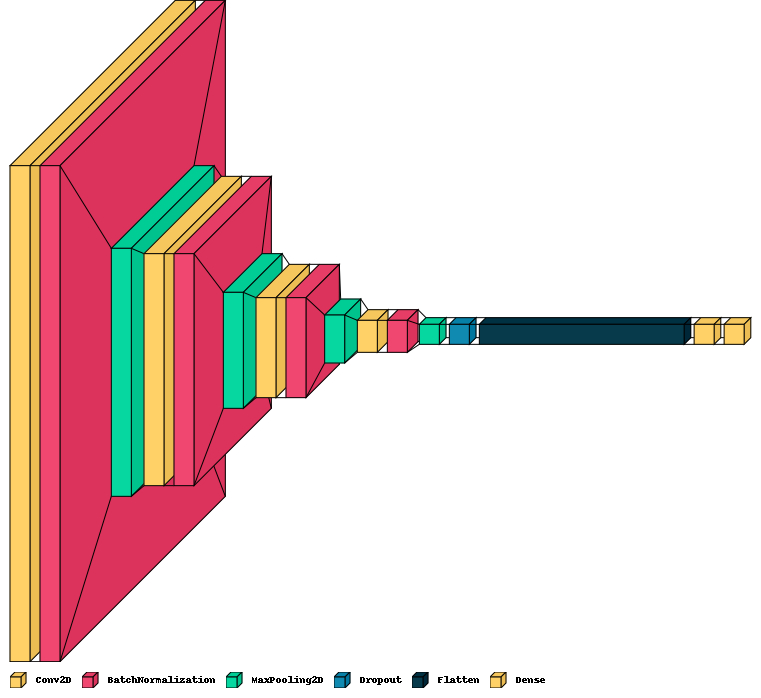

In [ ]:
#model visualisation, only works on google collab
#visualkeras.layered_view(cnn, legend=True, to_file='output.png')

In [ ]:
#callback to save the best weights of the model during training
checkpoint_path = 'training_1/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_dir,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)

cnn.compile(loss="sparse_categorical_crossentropy",
              optimizer= "adam",
              metrics=["accuracy"])

In [ ]:
#train_test_split
X_train, x_test, Y_train, y_test = train_test_split(x, y, test_size=0.1)
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2)

In [ ]:
#training the model
history = cnn.fit(x_train, y_train,
                  epochs=epochs,
                  batch_size=BATCH,
                  callbacks=[checkpoint],
                  workers=4,
                  validation_data=(x_val, y_val))

Epoch 1/20
163/163 [==============================] - 24s 89ms/step - loss: 0.3903 - accuracy: 0.8460 - val_loss: 1.8648 - val_accuracy: 0.4670
Epoch 2/20
163/163 [==============================] - 11s 69ms/step - loss: 0.2622 - accuracy: 0.8942 - val_loss: 2.2779 - val_accuracy: 0.4670
Epoch 3/20
163/163 [==============================] - 11s 69ms/step - loss: 0.2139 - accuracy: 0.9175 - val_loss: 0.6862 - val_accuracy: 0.6798
Epoch 4/20
163/163 [==============================] - 11s 70ms/step - loss: 0.1666 - accuracy: 0.9315 - val_loss: 0.2030 - val_accuracy: 0.9187
Epoch 5/20
163/163 [==============================] - 11s 69ms/step - loss: 0.1449 - accuracy: 0.9437 - val_loss: 0.2829 - val_accuracy: 0.8765
Epoch 6/20
163/163 [==============================] - 11s 69ms/step - loss: 0.1014 - accuracy: 0.9595 - val_loss: 0.1339 - val_accuracy: 0.9521
Epoch 7/20
163/163 [==============================] - 11s 68ms/step - loss: 0.0728 - accuracy: 0.9735 - val_loss: 0.1334 - val_accuracy:

In [ ]:
#VISUALIZE the training accuracy and loss over the epochs

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# save the model
#model_path = "CNN-trained.h5"
#cnn.save(model_path)

In [ ]:
cnn.load_weights(checkpoint_dir) #load best weights of model

#model accuracy
y_pred = cnn.predict(x_test)
predicted = np.argmax(y_pred, axis=-1)
accuracy = np.equal(y_test, predicted).mean()
print("Accuracy:", round(accuracy,3))

46/46 [==============================] - 0s 4ms/step
Accuracy: 0.979


In [ ]:
print(classification_report(y_test, predicted)) #evaluation

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       708
           1       0.98      0.98      0.98       741

    accuracy                           0.98      1449
   macro avg       0.98      0.98      0.98      1449
weighted avg       0.98      0.98      0.98      1449



In [ ]:
# Function to plot the confusion matrix
def confusion_mat(y_test,predicted):
    plt.figure(figsize=(5,5))
    sns.heatmap(confusion_matrix(y_test, predicted, normalize='true'),
            fmt='.1%',
            annot=True,
            cmap="Blues",
            xticklabels=["Covid","Normal"],
            yticklabels=["Covid","Normal"],
            annot_kws={"size": 14})
    plt.title('Confusion Matrix', {'fontsize':18})
    plt.yticks(np.arange(2)+0.5,rotation=0, fontsize="12", va="center")
    plt.xticks(np.arange(2)+0.5,rotation=0, fontsize="12", va="center")
    plt.show()

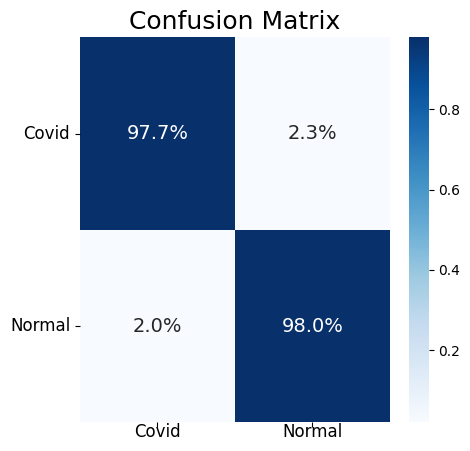

In [ ]:
confusion_mat(y_test,predicted)

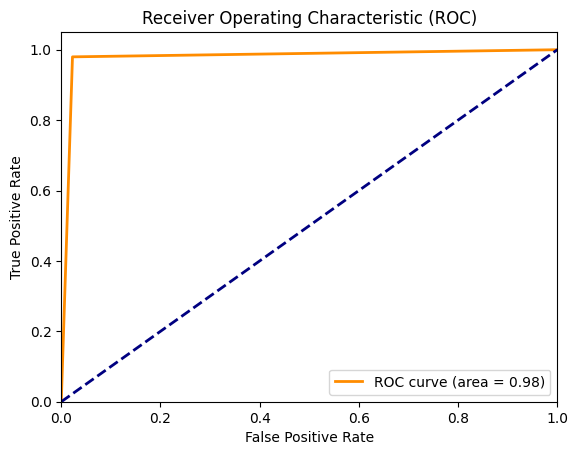

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUROC
fpr, tpr, thresholds = roc_curve(y_test, predicted)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#Look at the prediction and probability
rand = np.random.choice(range(0,1449)) #choose a random number from 0 to length of x_test

img=x_test[rand]

if y_test[rand] == 0.0:
    grd_trth = "Normal"
if y_test[rand] == 1.0:
    grd_trth = "Covid"

if y_pred[rand][0] < y_pred[rand][1]:
    pred_label = "Covid"
if y_pred[rand][0] > y_pred[rand][1]:
    pred_label = "Normal"

plt.figure(figsize=(12, 5))
print(f"Ground Truth: {grd_trth}  Predicted Label: {pred_label}  Probability: {np.max(y_pred[rand])}")
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Transfer Learning - ResNet50

In [ ]:
# Set the paths to the directories
data_dir = "/content/drive/MyDrive/BMI707" #"curated_data"
train_dir = os.path.join(data_dir, "Train")
test_dir = os.path.join(data_dir, "Test")

# Create Train and Test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define the subdirectories
subdirs = ["Covid", "Normal"]

# Define the ratio of data to be used for training (e.g., 90%)
train_ratio = 0.9

In [ ]:
########## Run only Once #########

#need paths to direct to images and not numpy array to use Generators ahead
#Preparing Train and Test direcotries

# Iterate over each class directory
for subdir in subdirs:
    # Get the list of images in the current class directory
    images = os.listdir(os.path.join(data_dir, subdir))
    # Shuffle the list of images
    random.shuffle(images)

    # Calculate the number of images for training and testing
    num_train = int(len(images) * train_ratio)
    num_test = len(images) - num_train

    # Create Train and Test directories for the current class
    os.makedirs(os.path.join(train_dir, subdir), exist_ok=True)
    os.makedirs(os.path.join(test_dir, subdir), exist_ok=True)

    # Copy images to Train directory
    for image in images[:num_train]:
        src = os.path.join(data_dir, subdir, image)
        dest = os.path.join(train_dir, subdir, image)
        shutil.copyfile(src, dest)

    # Copy images to Test directory
    for image in images[num_train:]:
        src = os.path.join(data_dir, subdir, image)
        dest = os.path.join(test_dir, subdir, image)
        shutil.copyfile(src, dest)

print("Data splitting and copying completed.")

In [ ]:
#train and test generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)

# Separate train and validation set using generators

train_set = train_datagen.flow_from_directory(train_dir,
                                              target_size=(img_size,img_size),
                                              batch_size=BATCH,
                                              classes=Classes,
                                              subset='training')

validation_set = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(img_size,img_size),
                                                   batch_size=BATCH,
                                                   classes=Classes,
                                                   subset='validation')

Found 10430 images belonging to 2 classes.
Found 2606 images belonging to 2 classes.


In [ ]:
print ("In train_set ")
for i in range(len (train_set.class_indices)):
    print(Classes[i],list(train_set.classes).count(i))
print ("")

print ("In validation_set ")
for i in range(len (validation_set.class_indices)):
    print(Classes[i],list(validation_set.classes).count(i))
print ("")

In train_set 
Covid 5467
Normal 4963

In validation_set 
Covid 1366
Normal 1240



In [ ]:
image_size = (img_size, img_size, 3)
freeze_layers = 2

In [ ]:
# Data is ready to be run into the base model, ResNet50, after being loaded & augmented
classifier = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=image_size)

x = classifier.output
x = Flatten()(x)
# Dropout layer
x = Dropout(0.2)(x)

# Dense layer
output_layer = Dense(2, activation='softmax', name='softmax')(x)

In [ ]:
# Freeze some layers on top before compiling, with the number of layers as a h-param
new_classifier = Model(inputs=classifier.input, outputs=output_layer)
for layer in new_classifier.layers[:freeze_layers]:
    layer.trainable = False
for layer in new_classifier.layers[freeze_layers:]:
    layer.trainable = True

In [ ]:
# Complie the model
new_classifier.compile(optimizer="Adam", #tf.keras.optimizers.RMSprop(learning_rate=0.0001)
                  loss='categorical_crossentropy', metrics=['accuracy'])

new_classifier.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
#callback to save best model weights
checkpoint_path = 'training_2/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_dir,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)

In [ ]:
# Train the model
history = new_classifier.fit(train_set,
                             batch_size=BATCH,
                             validation_data = validation_set,
                             workers=4,
                             callbacks=[checkpoint],
                             epochs = epochs)

Epoch 1/20


2024-04-25 21:33:23.266744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


163/163 [==============================] - ETA: 0s - loss: 0.4558 - accuracy: 0.8899

2024-04-25 21:35:35.452218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


163/163 [==============================] - 146s 866ms/step - loss: 0.4558 - accuracy: 0.8899 - val_loss: 0.6933 - val_accuracy: 0.4758
Epoch 2/20
163/163 [==============================] - 141s 860ms/step - loss: 0.1319 - accuracy: 0.9481 - val_loss: 0.6944 - val_accuracy: 0.4758
Epoch 3/20
163/163 [==============================] - 142s 869ms/step - loss: 0.1024 - accuracy: 0.9626 - val_loss: 0.7286 - val_accuracy: 0.2997
Epoch 4/20
163/163 [==============================] - 147s 894ms/step - loss: 0.0871 - accuracy: 0.9724 - val_loss: 0.8085 - val_accuracy: 0.4766
Epoch 5/20
163/163 [==============================] - 144s 878ms/step - loss: 0.4336 - accuracy: 0.8733 - val_loss: 457950.5625 - val_accuracy: 0.1040
Epoch 6/20
163/163 [==============================] - 198s 1s/step - loss: 0.9744 - accuracy: 0.8609 - val_loss: 3.8328 - val_accuracy: 0.6807
Epoch 7/20
163/163 [==============================] - 141s 863ms/step - loss: 0.4283 - accuracy: 0.8664 - val_loss: 247168.7188 - val

In [ ]:
# save the model
#model_path = "model-resnet50-trained.h5"
#new_classifier.save(model_path)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


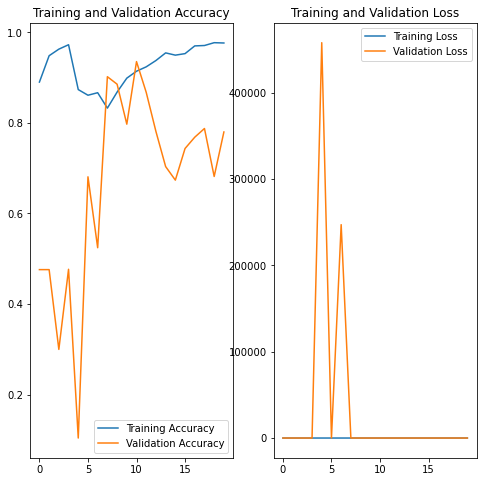

In [ ]:
#visualize the model training accuracy and loss over epochs

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#test generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_set = train_datagen.flow_from_directory(test_dir,
                                              target_size=(img_size,img_size),
                                              batch_size=BATCH,
                                              classes=Classes)

Found 1450 images belonging to 2 classes.


In [ ]:
test_dir

'curated_data/Test'

In [ ]:
#Load best weights
new_classifier.load_weights(checkpoint_dir)

In [ ]:
predictions = new_classifier.predict(test_set)
y_pred_resnet = np.argmax(predictions, axis=1)

y_test_resnet = test_set.classes

In [ ]:
print(classification_report(y_test_resnet, y_pred_resnet)) #evaluation

              precision    recall  f1-score   support

           0       0.50      0.59      0.54       760
           1       0.44      0.36      0.39       690

    accuracy                           0.48      1450
   macro avg       0.47      0.47      0.47      1450
weighted avg       0.47      0.48      0.47      1450



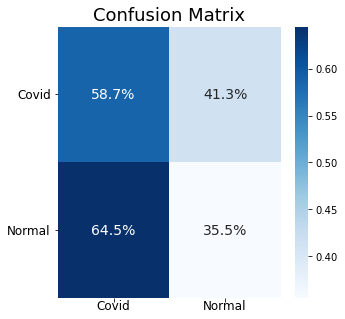

In [ ]:
confusion_mat(y_test_resnet, y_pred_resnet)

# Logistic Regression

In [ ]:
##Logistic Regression

# Reshape the tensors into a 2D array
image_train_shape = x_train.shape
image_test_shape = x_test.shape

flattened_x_train = x_train.reshape(image_train_shape[0], -1)
flattened_x_test = x_test.reshape(image_test_shape[0], -1)

# Scale the flattened images
scaler = StandardScaler()
scaled_x_train = scaler.fit_transform(flattened_x_train)
scaled_x_test = scaler.fit_transform(flattened_x_test)

In [ ]:
#Define the logistic regression model
log_reg_model = LogisticRegression()

#Train the model
log_reg_model.fit(scaled_x_train, y_train)

#Make predictions on test data
y_pred = log_reg_model.predict(scaled_x_test)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#Calculate Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

Accuracy: 0.9254658385093167
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       664
           1       0.94      0.92      0.93       785

    accuracy                           0.93      1449
   macro avg       0.92      0.93      0.93      1449
weighted avg       0.93      0.93      0.93      1449



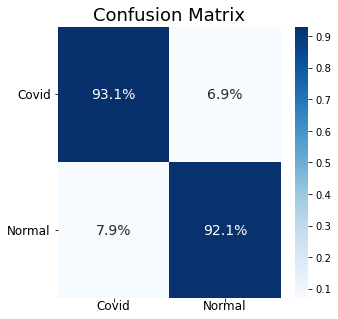

In [ ]:
# Calculate confusion matrix
confusion_mat(y_test, y_pred)

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Initialize Random Forest model
rf_model = RandomForestClassifier(n_estimators=50)

# Train the Random Forest model
rf_model.fit(flattened_x_train, y_train)

# Make predictions on test data
y_pred_rf = rf_model.predict(flattened_x_test)

In [ ]:
# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

#Calculate Precision, Recall, F1-score
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.9537612146307799
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       664
           1       0.98      0.93      0.96       785

    accuracy                           0.95      1449
   macro avg       0.95      0.96      0.95      1449
weighted avg       0.96      0.95      0.95      1449



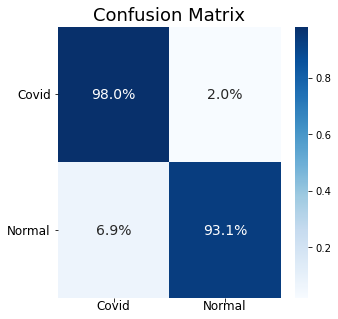

In [ ]:
# Calculate confusion matrix
confusion_mat(y_test, y_pred_rf)